
Accuracy: 94.91%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



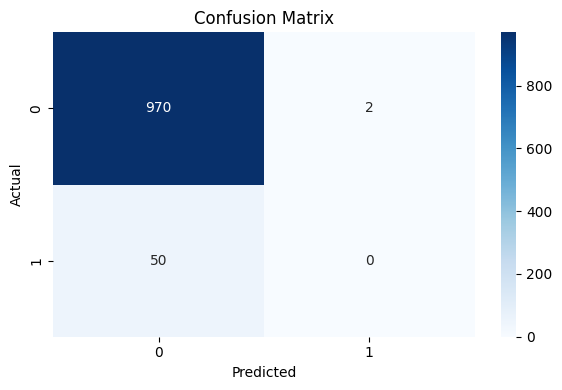

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
dataframe = pd.read_csv('cleaned_dataset.csv')
dataframe = dataframe.select_dtypes(include=[np.number])

features = dataframe.drop('stroke', axis=1)
labels = dataframe['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=5, min_samples_leaf=3):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X.values, y.values)

    def _build_tree(self, features, labels, depth=0):
        unique_labels = np.unique(labels)
        if depth >= self.max_depth or len(unique_labels) == 1 or len(labels) < self.min_samples_split:
            most_common = self._most_common_label(labels)
            return Node(value=most_common)

        best_feature_index, best_threshold = self._best_split(features, labels)
        if best_feature_index is None:
            most_common = self._most_common_label(labels)
            return Node(value=most_common)

        left_rows = []
        right_rows = []
        left_labels = []
        right_labels = []

        for i in range(len(features)):
            if features[i][best_feature_index] <= best_threshold:
                left_rows.append(features[i])
                left_labels.append(labels[i])
            else:
                right_rows.append(features[i])
                right_labels.append(labels[i])

        if len(left_labels) < self.min_samples_leaf or len(right_labels) < self.min_samples_leaf:
            most_common = self._most_common_label(labels)
            return Node(value=most_common)

        left_subtree = self._build_tree(np.array(left_rows), np.array(left_labels), depth + 1)
        right_subtree = self._build_tree(np.array(right_rows), np.array(right_labels), depth + 1)

        return Node(feature_index=best_feature_index, threshold=best_threshold,
                    left=left_subtree, right=right_subtree)

    def _best_split(self, features, labels):
        number_of_features = features.shape[1]
        best_gain = -1
        best_feature_index = None
        best_threshold = None

        for feature_index in range(number_of_features):
            unique_values = []
            for row in features:
                if row[feature_index] not in unique_values:
                    unique_values.append(row[feature_index])

            for threshold in unique_values:
                gain = self._information_gain(labels, features[:, feature_index], threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold

    def _information_gain(self, parent_labels, feature_column, threshold):
        left_labels = []
        right_labels = []

        for i in range(len(feature_column)):
            if feature_column[i] <= threshold:
                left_labels.append(parent_labels[i])
            else:
                right_labels.append(parent_labels[i])

        if len(left_labels) == 0 or len(right_labels) == 0:
            return 0

        parent_entropy = self._entropy(parent_labels)
        left_entropy = self._entropy(left_labels)
        right_entropy = self._entropy(right_labels)

        total_samples = len(parent_labels)
        weighted_entropy = (len(left_labels) / total_samples) * left_entropy + \
                           (len(right_labels) / total_samples) * right_entropy

        information_gain = parent_entropy - weighted_entropy
        return information_gain

    def _entropy(self, labels):
        label_counts = {}
        for label in labels:
            if label not in label_counts:
                label_counts[label] = 0
            label_counts[label] += 1

        entropy = 0
        total_labels = len(labels)
        for count in label_counts.values():
            probability = count / total_labels
            entropy -= probability * np.log2(probability)
        return entropy

    def _most_common_label(self, labels):
        label_counts = {}
        for label in labels:
            if label not in label_counts:
                label_counts[label] = 0
            label_counts[label] += 1

        most_common_label = None
        highest_count = -1
        for label, count in label_counts.items():
            if count > highest_count:
                highest_count = count
                most_common_label = label
        return most_common_label

    def predict(self, X):
        X_array = X.values
        predictions = []
        for row in X_array:
            prediction = self._traverse_tree(row, self.root)
            predictions.append(prediction)
        return np.array(predictions)

    def _traverse_tree(self, row, node):
        if node.value is not None:
            return node.value
        if row[node.feature_index] <= node.threshold:
            return self._traverse_tree(row, node.left)
        else:
            return self._traverse_tree(row, node.right)
tree_model = DecisionTree(max_depth=5, min_samples_split=5, min_samples_leaf=3)
tree_model.fit(X_train, y_train)
predicted_labels = tree_model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
print(f"\nAccuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, predicted_labels))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, predicted_labels), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
